In [31]:
import os
import cv2
import pandas as pd
from PIL import Image

In [32]:
nose_cascade = cv2.CascadeClassifier('haarcascade_mcs_nose.xml')

In [33]:
noses = []
ages = []

for i in os.listdir('data/crop_part1/')[0:8000]:
    split = i.split('_')
    ages.append(int(split[0]))      

    img = cv2.imread('data/crop_part1/' + i)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    noses_rect = nose_cascade.detectMultiScale(gray, 1.3, 5)

    if len(noses_rect) > 0:
        x, y, w, h = noses_rect[0]  
        nose_img = img[y:y+h, x:x+w] 

        noses.append(Image.fromarray(cv2.cvtColor(nose_img, cv2.COLOR_BGR2RGB)))
    else:
        noses.append(None) 

In [34]:
noses = pd.Series(noses, name='Noses')
ages = pd.Series(ages, name='Ages')

df = pd.concat([noses, ages], axis=1)

df

,Noses,Ages
0,<PIL.Image.Image image mode=RGB size=56x47 at ...,9
1,<PIL.Image.Image image mode=RGB size=52x43 at ...,1
2,<PIL.Image.Image image mode=RGB size=54x45 at ...,16
3,<PIL.Image.Image image mode=RGB size=47x39 at ...,1
4,<PIL.Image.Image image mode=RGB size=59x50 at ...,26
...,...,...
7995,<PIL.Image.Image image mode=RGB size=62x52 at ...,48
7996,<PIL.Image.Image image mode=RGB size=60x50 at ...,65
7997,<PIL.Image.Image image mode=RGB size=60x50 at ...,5
7998,<PIL.Image.Image image mode=RGB size=63x53 at ...,35


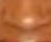

23


In [35]:
display(df['Noses'][900])
print(df['Ages'][900])

In [36]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical

# Rescale nose images to a fixed size, e.g., 32x32
processed_noses = []
labels = []

for i in range(len(df)):
    if df['Noses'][i] is not None:  # Filter out None values
        nose_img = df['Noses'][i].resize((32, 32))  # Resize to 32x32
        nose_array = img_to_array(nose_img) / 255.0  # Normalize pixel values
        processed_noses.append(nose_array)
        labels.append(df['Ages'][i])  

processed_noses = np.array(processed_noses)
labels = np.array(labels)

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(processed_noses, labels, test_size=0.2, random_state=42)

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (5, 5), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1)  # For age regression
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # MSE loss for regression

/opt/anaconda3/envs/bootcamp3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 826.8932 - mae: 23.1188 - val_loss: 586.1213 - val_mae: 20.5569
Epoch 2/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 599.5164 - mae: 20.0983 - val_loss: 454.9594 - val_mae: 17.0022
Epoch 3/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 480.3310 - mae: 17.7798 - val_loss: 382.9784 - val_mae: 15.8917
Epoch 4/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 435.0385 - mae: 16.6046 - val_loss: 412.5208 - val_mae: 14.8720
Epoch 5/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 410.9045 - mae: 15.8811 - val_loss: 362.7180 - val_mae: 15.1443
Epoch 6/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 411.8683 - mae: 15.9341 - val_loss: 361.4735 - val_mae: 14.5569
Epoch 7/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 416.8472 - mae: 15.9779 - val_loss: 345.5211 - val_mae: 14.4216
Epoch 8/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 389.8552 - mae: 15.2183 - val_loss: 349.2709 - val_mae: 14.9239
Epoch 9/

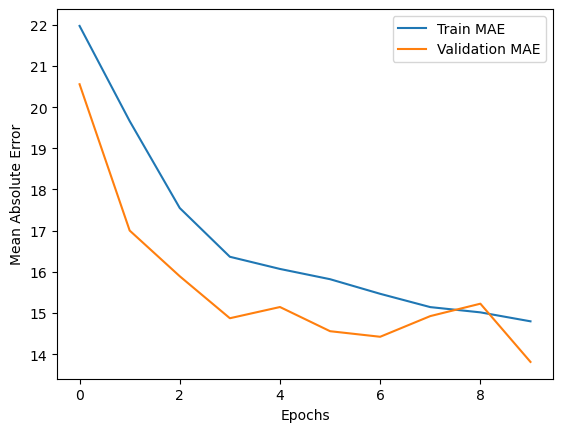

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 333.3741 - mae: 13.8635
Test MAE: 13.810602188110352


In [40]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

# Model Evaluation
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae}")

In [ ]:
test_loss, test_mae = model.evaluate(X_test, y_test)
model_results_2 = test_mae 
history_2 = history
model_2 = model
df_2 = df

In [58]:
nose_image = df['Noses'][900]  # Get the nose image
display(nose_image)

if nose_image is not None:
    nose_image = nose_image.resize((32, 32))
    nose_array = img_to_array(nose_image) / 255.0
    prepared_image = np.expand_dims(nose_array, axis=0)
    
    predicted_nose_age = model.predict(prepared_image)
    
    print(f"Age: {predicted_nose_age[0][0]:.2f}")
else:
    print("No nose image found")